In [1]:
# Upload from your local system
from google.colab import files
uploaded = files.upload()

# Load it with pandas
import pandas as pd
df = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')


Saving OnlineRetail.csv to OnlineRetail (1).csv


In [2]:
df.shape  # Rows and columns
df.columns  # Column names
df.head()  # Peek at the first few rows
df.info()  # Data types and missing values
df.describe()  # Summary stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Cleaning

In [3]:
df = df.dropna(subset=['CustomerID'])


In [4]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [5]:
df = df.drop_duplicates()

In [6]:
df['CustomerID'] = df['CustomerID'].astype(str)

In [7]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [8]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
TotalPrice,0


In [9]:
df.describe()

,Quantity,UnitPrice,TotalPrice
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,22.631500
std,180.492832,22.241836,311.099224
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


In [10]:
df['CustomerID'].nunique()

4338

In [11]:
df.isnull().sum()          # Check for leftover missing values
df.describe()              # Confirm Quantity and UnitPrice are now all positive
df['CustomerID'].nunique() # How many unique customers you have now

4338

# Building RFM - Feature Engineering


In [12]:
import pandas as pd

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # make sure it's datetime

# Reference date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [13]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})


In [14]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)


In [15]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


break


In [17]:
# Scoring: 4 is best, 1 is worst

# Recency: lower is better
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# Frequency: higher is better
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Monetary: higher is better
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine into one string (optional but helpful)
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)


In [18]:
rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm[['R_score', 'F_score', 'M_score']].astype(int).sum(axis=1)


In [19]:
def rfm_level(score):
    if score >= 9:
        return 'Top Customers'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist'
    else:
        return 'Needs Attention'

rfm['Customer_Level'] = rfm['RFM_Score'].apply(rfm_level)


In [20]:
segment_analysis = rfm.groupby('Customer_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'count'
}).sort_values(by='RFM_Score', ascending=False)

print(segment_analysis)


                       Recency  Frequency     Monetary  RFM_Score
Customer_Level                                                   
Top Customers        25.478235   8.389386  4404.812756       1677
Potential Loyalist  114.124368   1.469161   517.764925        989
Loyal Customers      70.172055   2.491917   935.008236        866
Needs Attention     229.600496   1.057072   221.527618        806


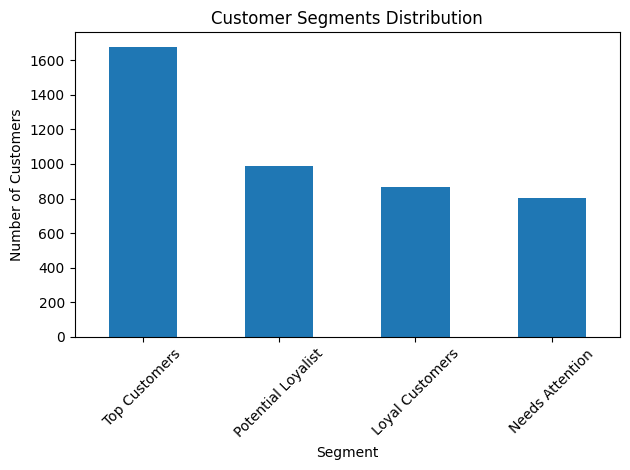

In [21]:
import matplotlib.pyplot as plt

rfm['Customer_Level'].value_counts().plot(kind='bar')
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
from sklearn.preprocessing import StandardScaler

# Create a new dataframe to avoid affecting original
rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)


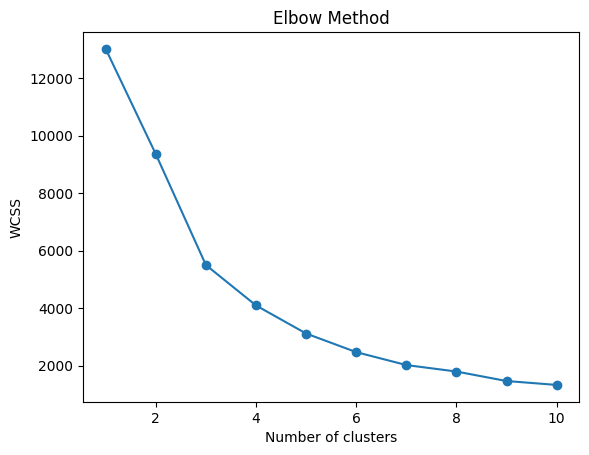

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()


In [24]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(rfm_scaled)

rfm['Cluster'] = kmeans.labels_


In [25]:
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
print(cluster_summary)


         Recency  Frequency  Monetary
Cluster                              
0           43.7        3.7    1353.6
1          248.1        1.6     478.8
2            7.4       82.5  127188.0
3           15.5       22.3   12690.5


In [26]:
print(rfm['Cluster'].value_counts())


Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64


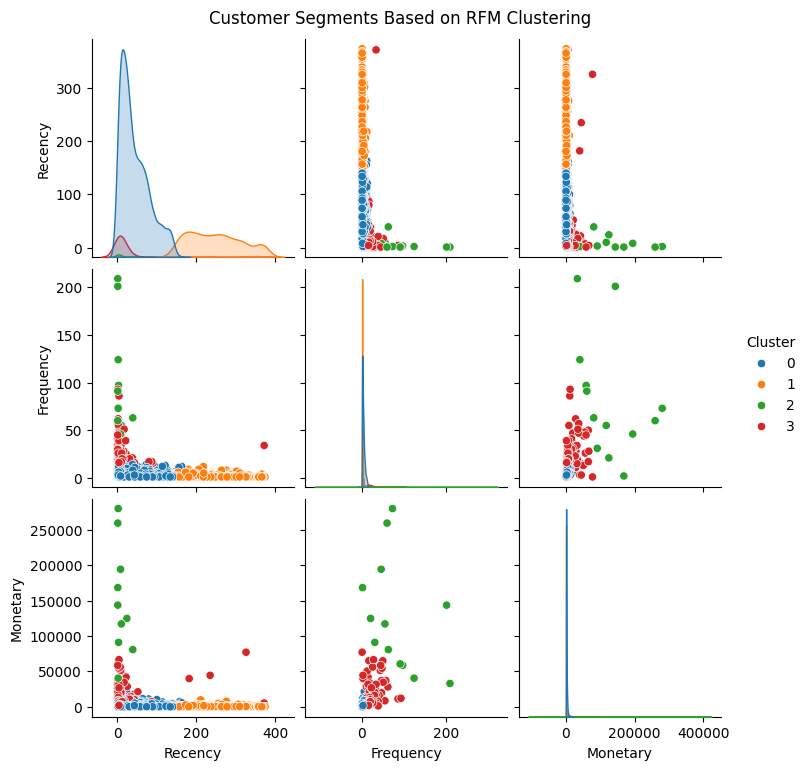

In [27]:
import seaborn as sns

sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='tab10')
plt.suptitle("Customer Segments Based on RFM Clustering", y=1.02)
plt.show()


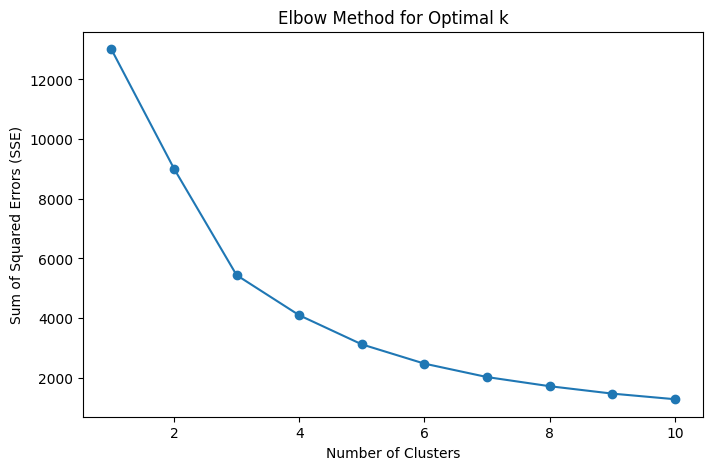

In [16]:
# Step 1: Import needed libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 2: Scale RFM features (Recency, Frequency, Monetary)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Step 3: Use the Elbow Method to find the best number of clusters (k)
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [17]:
# Step 4: Choose optimal k (based on elbow plot), e.g., k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(rfm_scaled)


In [18]:
# Step 5: Assign cluster labels to the original RFM dataframe
rfm['Cluster'] = clusters

In [19]:
# Step 6: Analyze cluster profiles by computing mean of RFM metrics per cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster':'Count'}).reset_index()

print(cluster_summary)

   Cluster     Recency  Frequency       Monetary  Count
0        0   43.702685   3.682711    1353.625312   3054
1        1  248.075914   1.552015     478.848773   1067
2        2    7.384615  82.538462  127187.959231     13
3        3   15.500000  22.333333   12690.500392    204


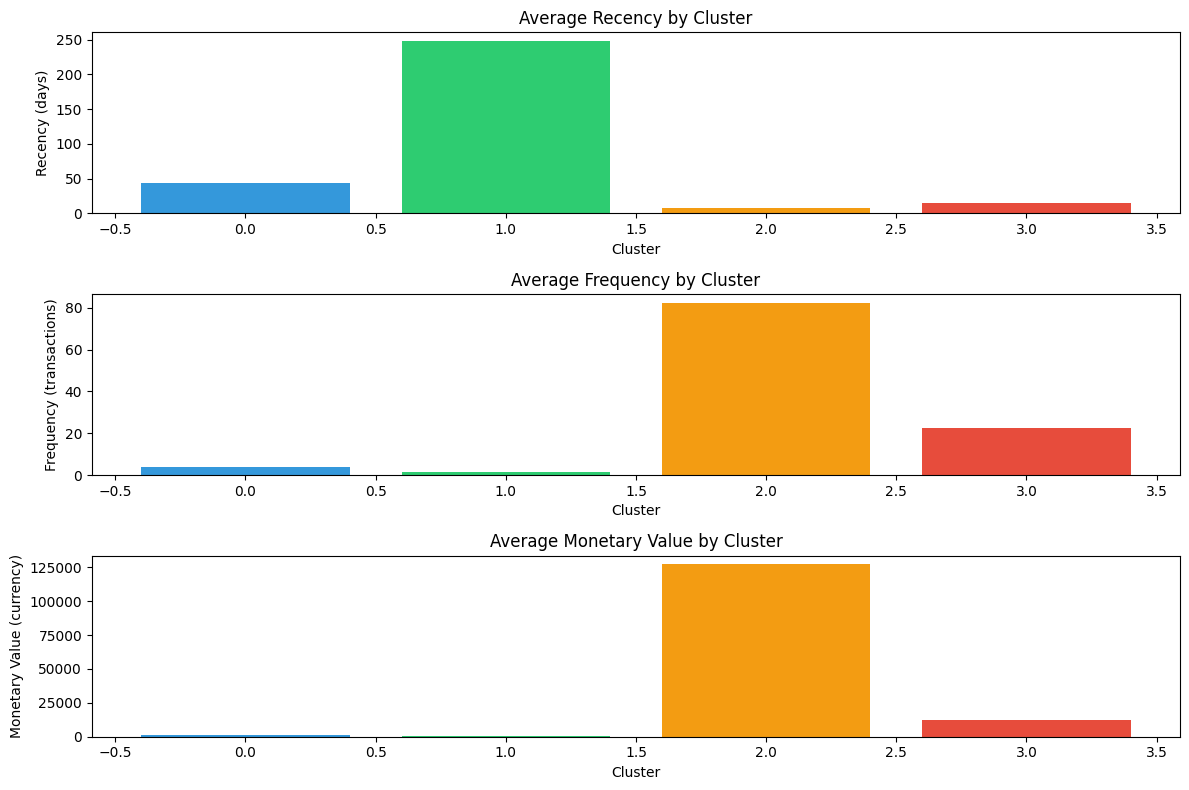

In [20]:
# Step 7: Visualize the average RFM metrics for each cluster
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.bar(cluster_summary['Cluster'], cluster_summary['Recency'], color=colors)
plt.title('Average Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency (days)')

plt.subplot(3, 1, 2)
plt.bar(cluster_summary['Cluster'], cluster_summary['Frequency'], color=colors)
plt.title('Average Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency (transactions)')

plt.subplot(3, 1, 3)
plt.bar(cluster_summary['Cluster'], cluster_summary['Monetary'], color=colors)
plt.title('Average Monetary Value by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary Value (currency)')

plt.tight_layout()
plt.show()

In [21]:
# Step 8: Assign descriptive names to clusters based on their profiles (optional)
def name_clusters(row):
    if row['Recency'] < cluster_summary['Recency'].median() and row['Frequency'] > cluster_summary['Frequency'].median() and row['Monetary'] > cluster_summary['Monetary'].median():
        return 'High Value'
    elif row['Recency'] < cluster_summary['Recency'].median():
        return 'Loyal Customers'
    elif row['Recency'] > cluster_summary['Recency'].median():
        return 'At Risk'
    else:
        return 'Others'

cluster_summary['Segment Name'] = cluster_summary.apply(name_clusters, axis=1)
print(cluster_summary[['Cluster', 'Segment Name']])

   Cluster Segment Name
0        0      At Risk
1        1      At Risk
2        2   High Value
3        3   High Value


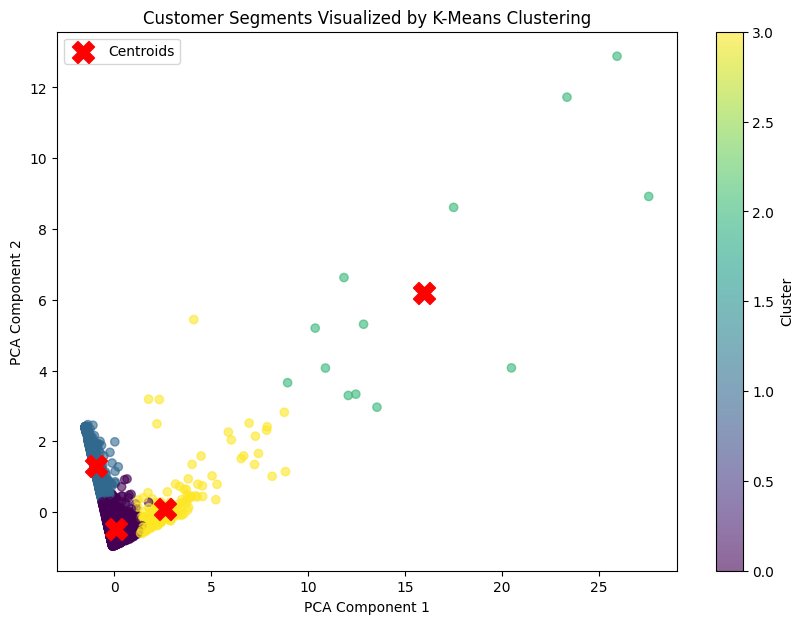

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have your RFM dataframe `rfm` and cluster labels in 'Cluster'

# Step 1: Scale your RFM data if not done
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Step 2: Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Step 3: Plot the clusters with colors according to cluster label
plt.figure(figsize=(10, 7))
scatter = plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments Visualized by K-Means Clustering')

# Optional: Plot cluster centers after transforming them with PCA
from sklearn.cluster import KMeans

# Refit KMeans so you have the fitted model for cluster centers
kmeans = KMeans(n_clusters=len(rfm['Cluster'].unique()), random_state=42, n_init=10)
kmeans.fit(rfm_scaled)
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=250, c='red', marker='X', label='Centroids')

plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()
